In [1]:
import numpy as np
from numpy import unravel_index
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import random
from scipy.optimize import least_squares
import sys
from vector_class import TripleVector
from scipy.optimize import curve_fit



# Parameters

In [2]:
A_min = 1e3 # Bq
A_max = 2e3 # Bq
A_b = 5e-5 # Bq
h = 10 # m
dt = 100 # the pause on each point od the grid in s
x_max = 4; sigma_x = 0.1 # m
y_max = 4; sigma_y = 0.1 # m
grid = 8
n_bins = 20
K = 0.1 # is somewhere in the interval [0, 1]
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq

radiation = {"A_min": A_min, "A_max": A_max, "A_b": A_b, "dose_factor": F}
detector = {"h": h, "dt": dt, "x_max": x_max, "y_max": y_max, "grid": grid, "detector_constant": K} # the detector constant tells us the quality of the detector

n_points = 10 # fot the random_flyover() -> number of random points generated


## Subsidariy code

In [85]:
 # it equals to the activity
def activity(source, x, y, h, ru=0, rv=0):
    u, v, A0 = source[0], source[1], source[2] # u, v are the coordinates of the source and A0 is its activity
    return (A0*(ru**2 + rv**2 + h**2)) / ((x - (u - ru))**2 + (y - (v - rv))**2 + h**2)

def point_source(x_max, y_max, A_min, A_max, x_min=0, y_min=0):
    if (x_min == 0) and (y_min == 0):    
        return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]
    else:
        return [random.uniform(x_min, x_max), random.uniform(y_min, y_max), random.uniform(A_min, A_max)]

def simulated_event(source, x, y, h, grid_x_noise, grid_y_noise, noise=[], n="None", m="None"):
    A = activity(source, x, y, h)
    A_det = A * (1 - K)
    N = np.random.poisson(A_det * dt)
    N_b = np.random.poisson(A_b * dt)# background radiation

    # Add noise to the location data because of the GPS uncertianty

    if len(noise) != 0:
        if (n != "None" and m != "None"):
            sigma_x = noise[0]; sigma_y = noise[1]
            grid_x_noise[n, m] = x + np.random.normal(0, sigma_x)
            grid_y_noise[n, m] = y + np.random.normal(0, sigma_y)
        else:
            sigma_x = noise[0]; sigma_y = noise[1]
            x += np.random.normal(0, sigma_x)
            y += np.random.normal(0, sigma_y)

    return {"N": N, "N_b": N_b, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "x": x, "y": y}


## ZIG-ZAG Flyover

### Flyover

In [86]:

# Noise is a list that contanins the standard deviations of x/y coordinates as a result of the error of the detector
def flyover(radiation, detector, source = [], noise = []):
    A_min, A_max, A_b, F = radiation["A_min"], radiation["A_max"], radiation["A_b"], radiation["dose_factor"]
    h, dt, x_max, y_max, grid, K = detector["h"], detector["dt"], detector["x_max"], detector["y_max"], detector["grid"], detector["detector_constant"]
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid

    grid_x, grid_y = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    
    # If the source is not specified, then it is randomly generated 
    if len(source) == 0: 
        source = point_source(x_max, y_max, A_min, A_max)
    
    HDs = np.zeros((int(N_grid), int(N_grid))); dHDs = np.zeros((int(N_grid), int(N_grid)))
    n, m = N_grid - 1, 0
    y = -y_max + square_y/2
    i = 1
    for x in xs:
        while abs(y) <= y_max:
            
            # Simulate the number of events according to the Poisson distribution and add noise

            event = simulated_event(source, x, y, h, grid_x_noise, grid_y_noise, noise, n, m)
            N = event["N"]; N_b = event["N_b"]; grid_x_noise = event["grid_x_noise"]; grid_y_noise = event["grid_y_noise"]

            HDs[n, m] = F * (N + N_b)
            dHDs[n, m] = F * np.sqrt(N + N_b)
            
            grid_x[n, m] = x; grid_y[n, m] = y
            y += (square_y)*i
            n -= 1*i
        n += 1*i; i = i * (-1); y += (square_y)*i; m += 1
    i_max, j_max = unravel_index(HDs.argmax(), HDs.shape)
    x_c, y_c = grid_x[i_max, j_max], grid_y[i_max, j_max]
    maxI_range = {"xrange": (x_c - square_x/2, x_c + square_x/2), "yrange": (y_c - square_x/2, y_c + square_x/2)}

    return {"m_dose": HDs, "dm_dose": dHDs, "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "hotspot": maxI_range, "square_x": square_x, "square_y": square_y}

measurement = flyover(radiation, detector)

# hotspot = measurement["hotspot"]
# x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]



### Location from flyover

#### Scipy least squares

In [57]:
# Using the Levenberg-Marquardt method with scipy least squares
def locationLM(measurement, radiation, detector):
    A_min, A_max = radiation['A_min'], radiation['A_max']
    h = detector['h']
    hotspot = measurement['hotspot']
    x_0, x_1 = hotspot['xrange']; y_0, y_1 = hotspot['yrange']

    def dose(source, x, y):
        u, v, alpha = source[0], source[1], source[2]
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    # def N(source, x, y):
    #     return N_func(source, x, y, h, dt)

    grid_x, grid_y = measurement['grid_x'], measurement['grid_y']
    HDs = measurement['m_dose']

    def fun(source):
        return (dose(source, grid_x, grid_y) - HDs).flatten()

    # guess = point_source(x_0, y_0, A_min, A_max, x_1, y_1)
    source0 = [1, 1, 1]
    res = least_squares(fun, source0, method="lm")

    return res["x"]

measurement = flyover(radiation, detector)
sourceLM = locationLM(measurement, radiation, detector)

#### Scipy curve fit

In [56]:
# Also location with LM method, only now using the curve_fit scipy.optimize function 
def locationCF(measurement, radiation, detector, noise = []):
    HDs, dHDs, grid_x, grid_y, hotspot = measurement['m_dose'], measurement['dm_dose'], measurement['grid_x'], measurement['grid_y'], measurement["hotspot"] # in example Z, here Is
    grid_x_noise = measurement['grid_x_noise']; grid_y_noise = measurement['grid_y_noise']
    h = detector["h"]

    x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]

    if len(noise) == 0:
        XY = np.vstack((grid_x.ravel(), grid_y.ravel()))
    else:
        XY = np.vstack((grid_x_noise.ravel(), grid_y_noise.ravel()))
    source0 = [random.uniform(x_0, x_1), random.uniform(y_0, y_1), 1]
    
    def dose(x, y, u, v, alpha):
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += dose(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(__dose, XY, HDs.ravel(), source0, sigma = dHDs.ravel(), absolute_sigma = True, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

    return popt, perr, MyDict


sourceCF = locationCF(measurement, radiation, detector)

### Combination

In [63]:
def const(K, F):
    return F / (1 - K)

# combines the detector flyover and the location detection
def combination(radiation, detector, source=[], noise=[]):
    measurement = flyover(radiation, detector, source, noise)
    sourceLM = locationLM(measurement, radiation, detector)
    sourceCF, stDev = locationCF(measurement, radiation, detector, noise)[0], locationCF(measurement, radiation, detector, noise)[1]
    return {'measurement': measurement, 'source_locationLM': sourceLM, 'source_locationCF': sourceCF, "sourceCF_stDev": stDev}

data = combination(radiation, detector, [], [])



### Visualization

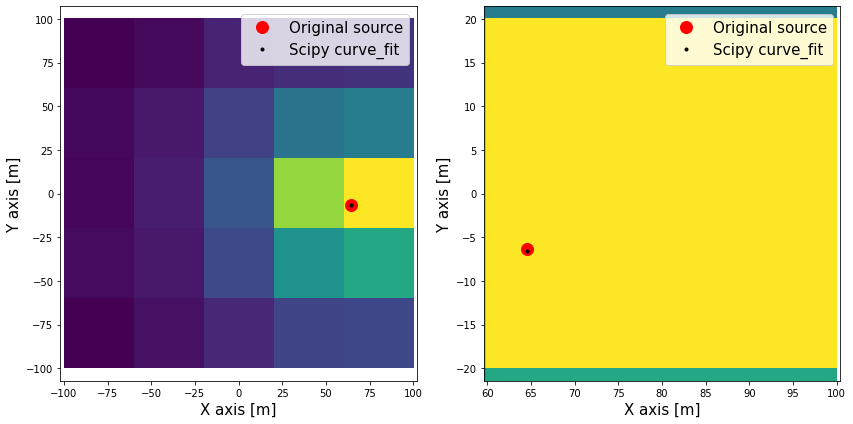

In [69]:
def visualize(measurement, x_max, y_max, points):
    X, Y = measurement['source'][0], measurement['source'][1]
    u1, v1 = points[0][0], points[0][1]
    u2, v2 = points[1][0], points[1][1]
    # print((u1, v1), (u2, v2))

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
    im = ax1.imshow(measurement['m_dose'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax1.plot(X, Y, "o", color = 'r', ms=12, label = "Original source")
    # ax1.plot(u1, v1, "o", color = 'g', ms=6, label = "Scipy least_square")
    ax1.plot(u2, v2, "o", color = 'k', ms=3, label = "Scipy curve_fit")

    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax1.legend(fontsize = 15)

    hotspot = measurement['hotspot']
    x_0, x_1 = hotspot['xrange']; y_0, y_1 = hotspot['yrange']

    ax2.imshow(measurement['m_dose'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax2.plot(X, Y, "o", color = 'r', ms=12, label = "Original source")
    # ax2.plot(u1, v1, "o", color = 'g', ms=6, label = "Scipy least_square")
    ax2.plot(u2, v2, "o", color = 'k', ms=3, label = "Scipy curve_fit")
    ax2.axis("equal")
    ax2.set_xlim(x_0, x_1)
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(y_0, y_1)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)    

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]
    # print(measurement["intensities_array"], '\n', measurement["grid_x"], '\n', measurement["grid_y"])

# 0.1, 0.1, 100
data = combination(radiation, detector, [], [])
visualize(data['measurement'], detector['x_max'], detector['y_max'], [data['source_locationLM'], data['source_locationCF']])


## Random flyover

### Flyover

In [87]:
# Noise is a list that contanins the standard deviations of x/y coordinates as a result of the error of the detector
def random_flyover(n_points, radiation, detector, source = [], noise = []):
    A_min, A_max, A_b, F = radiation["A_min"], radiation["A_max"], radiation["A_b"], radiation["dose_factor"]
    h, dt, x_max, y_max, grid, K = detector["h"], detector["dt"], detector["x_max"], detector["y_max"], detector["grid"], detector["detector_constant"]
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))
    grid_x, grid_y = np.meshgrid(xs, np.flip(ys))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))

    # If the source is not specified, then it is randomly generated 
    if len(source) == 0: 
        source = point_source(x_max, y_max, A_min, A_max)
    i = 0
    points = np.zeros((1, 4))
    while i < n_points:
        x = random.uniform(-x_max, x_max); y = random.uniform(-y_max, y_max)

        # Simulate the number of events acoording to the Poisson distribution and add noise

        event = simulated_event(source, x, y, h, grid_x_noise, grid_y_noise, noise)
        N = event['N']; N_b = event['N_b']; x = event['x']; y = event['y']

        HD = F * (N + N_b); dHD = F * np.sqrt(N + N_b)
        row = np.array([x, y, HD, dHD])
        points = np.vstack((points, row))          
        i += 1

    return {"points": points[1:, :], "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "square_x": square_x, "square_y": square_y}


### Location from measurement

In [74]:
# Fit

def random_locationCF(measurement, detector):
    points = measurement['points']
    h, x_max, y_max = detector['h'], detector['x_max'], detector['y_max']

    XY = np.vstack((points[:, 0], points[:, 1]))
    HDs = points[:, 2]
    dHDs = points[:, 3]

    source0 = [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), 1]

    def dose(x, y, u, v, alpha):
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += dose(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(__dose, XY, HDs, source0, sigma = dHDs, absolute_sigma = True, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

    return popt, perr, MyDict


### Combination

In [75]:
# Combination

def random_combination(n_points, radiation, detector, source=[], noise=[]):
    measurement = random_flyover(n_points, radiation, detector, source, noise)
    sourceCF, stDev = random_locationCF(measurement, detector)[0], random_locationCF(measurement, detector)[1]
    return {'measurement': measurement, 'sourceCF': sourceCF, 'sourceCF_stDev': stDev}

### Visualization

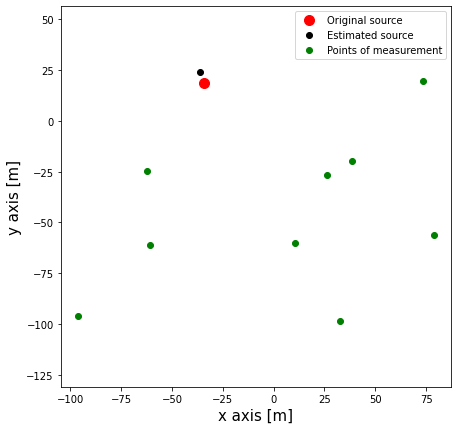

In [82]:
# Visualization

def random_visualize(data):

    fig, ax = plt.subplots(figsize = (7, 7))

    original = data['measurement']['source']
    estimate = data['sourceCF']
    measured = data['measurement']['points']

    ax.plot(original[0], original[1], "o", c="r", ms=10, label = "Original source")
    ax.plot(estimate[0], estimate[1], "o", c="k", ms=6, label = "Estimated source")
    ax.plot(measured[:, 0], measured[:, 1], "o", c="g", label = "Points of measurement")

    ax.set_xlabel('x axis [m]', fontsize=15)
    # plt.xticks(fontsize=14)
    ax.set_ylabel('y axis [m]', fontsize=15)
    # plt.yticks(fontsize=14)
    
    ax.axis("equal")
    plt.legend()
    plt.show()

data_random = random_combination(n_points, radiation, detector, [-34.06413743466325, 18.72494667983291, 1207.4224164766233], [])
random_visualize(data_random)



# Code description

u = -34.09956123479984 ± 0.19237334688971938 m
v = 18.469005816350712 ± 0.18707676894163602 m
alpha = 1078260.4098087314 ± 3081.266635873811 


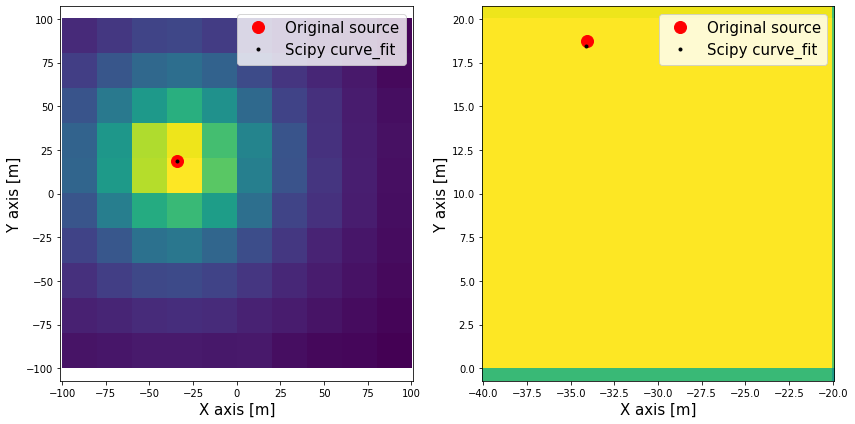

u = -33.263964211672366 ± 0.7164592943113491 m
v = 19.16785899319182 ± 0.6922120521075446 m
alpha = 1085254.875605915 ± 11824.903974088698 


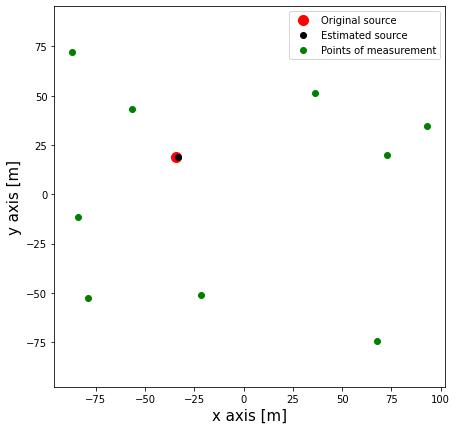

In [90]:
# DESCRIPTION OF THE CODE

# In comparisson to the code in simple_SPS.ipynb there are a few minor changes. The intensity function is defined diferently. It takes into
# consideration two points, the source of the radiation and the position of a measurement. Flyover() is very similar to the older version 
# it just uses the new intensity and also the activity of the source is randomly generated - it is one of the parameters which we are fitting.

# locationLM() is the major chenge. We use the scipy least square Levenberg-marquardt method to minimize the square residuals of the model 
# intensity and the measured intensity. Through the minimization we can output the paramaters which we are searching for - u, v and A0 (x/y 
# coordinates of the source and its intensity).

# visualize() shows us that this method is much more accurate then the previously used location searching method.

# For now two seperate codes where the core principle is the same: make measurements with a detector, fit data to the source and than combine
# these two to visualize the final result. The main diference is that in ZIG-ZAG example the detector flys over in a up and down pattern along 
# the area of measurement. But in the random flyover the measurement points ar picked randomly.

# SHARED PARAMETERS (USED IN BOTH ZIG-ZAG AND RANDOM FLYOVER)
A_min = 1e3; A_max = 1.5e3 # borders between which the activity of the source is randomly selected 
A_b = 5e-5 # background activity in Bq
h = 40 # hight at which the detector flies over in m
x_max = 100 # Size of the area of flyover in positive x direction in m (the whole grid extends also in the negative direction the same amount)
y_max = 100 # Size of the area of flyover in positive y direction in m (the whole grid extends also in the negative direction the same amount)
dt = 10 # the pause on each point od the grid in s
noise = [5, 5] # list that contains the standard deviation of the x and y coordinates in in m
K = 0.6 # constant between 0 and 1 which contains the information on the quality of the detector, a better detector has a smaller constante 
        # then then an inferior detector
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq


# ZIG_ZAG PARAMETERS
grid = 10 # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the number of 
         # radioactive decays. Grid is the number of these areas in x direction and y direction. It must be an INTEGER!

# RANDOM PARAMETERS
n_points = 9 # number of points randomlly selected in the grid


# Combinig the parameters into a list so that the data is more compacted
radiation = {'A_min': A_min, 'A_max': A_max, 'A_b': A_b, 'dose_factor': F}
detector = {'h': h, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid, 'detector_constant': K}

# Flying over the surface
data = combination(radiation, detector, [-34.06413743466325, 18.72494667983291, 1207.4224164766233], [])
# print(data["sourceCF_stDev"])
# Print out the fitted parameters with their absolute errors (standard deviation)
print("u =", data["source_locationCF"][0], r'±', data["sourceCF_stDev"][0], "m")
print("v =", data["source_locationCF"][1], r'±', data["sourceCF_stDev"][1], "m")
print("alpha =", data["source_locationCF"][2], r'±', data["sourceCF_stDev"][2], "")

visualize(data["measurement"], detector["x_max"], detector["y_max"], [data["source_locationLM"], data["source_locationCF"]])

# Random points over the surface
data_random = random_combination(n_points, radiation, detector, [-34.06413743466325, 18.72494667983291, 1207.4224164766233], [])
print("u =", data_random["sourceCF"][0], r'±', data_random["sourceCF_stDev"][0], "m")
print("v =", data_random["sourceCF"][1], r'±', data_random["sourceCF_stDev"][1], "m")
print("alpha =", data_random["sourceCF"][2], r'±', data_random["sourceCF_stDev"][2], "")

random_visualize(data_random)


# Analysis

## Presenting some data

In [15]:
testSource = point_source(x_max, y_max, A_min, A_max)
testSource1 = point_source(x_max, y_max, A_min, A_max)
testSource2 = point_source(x_max, y_max, A_min, A_max)
source00 = [0, 0, testSource[2]]

print(testSource)
source00

[54.95118406522985, -44.650259099778154, 1237.6539134928682]


[0, 0, 1237.6539134928682]

In [16]:
# change the grid so that with a grid with more tiles the worse detector can get similar error to the first one
grid0, grid2 = 10, 20
h0 = 40; h1 = 30; h2 = 100 
noise = [1, 1]


# Analysis for detectors without noise, detector0 is an ideal detector and detector1 is a superior real detector to the real detector2
detector0 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid2, 'detector_constant': 0.}
detector1 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid2, 'detector_constant': 0.1}
detector2 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid2, 'detector_constant': 0.8}    

# We generate the data measurement and analysis for the same source, same grid and everything, the only difference between the detectors is K
data0 = combination(radiation, detector0, testSource, noise)
data1 = combination(radiation, detector1, source00, noise)
data2 = combination(radiation, detector1, testSource, noise)

# Estimated source positions (with errors) 
u0, du0 = data0["source_locationCF"][0], data0["sourceCF_stDev"][0]; v0, dv0 = data0["source_locationCF"][1], data0["sourceCF_stDev"][1] 
u1, du1 = data1["source_locationCF"][0], data1["sourceCF_stDev"][0]; v1, dv1 = data1["source_locationCF"][1], data1["sourceCF_stDev"][1]
u2, du2 = data2["source_locationCF"][0], data2["sourceCF_stDev"][0]; v2, dv2 = data2["source_locationCF"][1], data2["sourceCF_stDev"][1]

# The (u, v) ± (du, dv)
# print("DETECTOR0:", "\n", (u0, v0), r'±', (du0, dv0), "m")
# print("DETECTOR1:", "\n", (u1, v1), r'±', (du1, dv1), "m")
# print("DETECTOR2:", "\n", (u2, v2), r'±', (du2, dv2), "m")

# Comparison between the error of the measurement for (0, 0) and (x, y) position of the source
print("Source in center:", "\n", (u1, v1), "+/-", (du1, dv1))
print("Source ourside:", "\n", (u2, v2), "+/-", (du2, dv2))




Source in center: 
 (-0.12579929708216325, -0.0847139360394734) +/- (0.060395709573217424, 0.060456785658022705)
Source ourside: 
 (54.9271946967358, -44.5144636949364) +/- (0.07129473176921554, 0.06781746683396464)


## Error comparisson for different detector/measurement properties

In [26]:
# errors compared to detectors with different grid, heights and qualities

def lin(x, k, n):
    return k*x + n

def compK(radiation, detector, source, noise= []):
    Ks = np.linspace(0, 0.8, 20)
    dus = []
    dvs = []
    for K in Ks:
        detector['detector_constant'] = K 
        data = combination(radiation, detector, source, noise)
        dus.append(data['sourceCF_stDev'][0]/abs(data['source_locationCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['source_locationCF'][1]))
    draw(Ks, [dus, dvs], "Coefficient of the detector, K []", "Relative error []")


def compH(radiation, detector, source, noise= []):
    hs = np.linspace(20, 100, 20)
    dus = []
    dvs = []
    for h in hs:
        detector['h'] = h
        data = combination(radiation, detector, source, noise)
        dus.append(data['sourceCF_stDev'][0]/abs(data['source_locationCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['source_locationCF'][1]))
    draw(hs, [dus, dvs], "Height of flyover [m]", "Relative error []")
    fit_func(lin, hs, dus, "Height of flyover [m]", "Relative error []")

def compG(radiation, detector, source, noise = []):
    grids = np.linspace(2, 42, 10)
    dus = []
    dvs = []
    for grid in grids:
        detector['grid'] = int(grid)
        data = combination(radiation, detector, source, noise)
        dus.append(data['sourceCF_stDev'][0]/abs(data['source_locationCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['source_locationCF'][1]))
    draw(grids, [dus, dvs], "Number of grid points []", "Absolute error [m]")

def compT(radiation, detector, source, noise = []):
    dts = np. linspace(1, 1000, 20)
    dus = []
    dvs = []
    for dt in dts:
        detector['dt'] = dt
        data = combination(radiation, detector, source, noise)
        dus.append(data['sourceCF_stDev'][0])
        dvs.append(data['sourceCF_stDev'][1])
    draw(dts, [dus, dvs], "Time of measurement at each grid point [s]", "Absolute error [m]")

def comp_randToG(radiation, detetctor, source, noise = []):
    grids = np.linspace(4, 42, 20)
    dus = []
    dvs = []
    measured_points = []
    for grid in grids:
        detector['grid'] = int(grid); n_points = int(grid)**2
        measured_points.append(n_points)
        data_R = random_combination(n_points, radiation, detector, source, noise)
        data_G = combination(radiation, detector, source, noise)
        d_UR = data_R['sourceCF_stDev'][0]; d_UG = data_G['sourceCF_stDev'][0]
        d_VR = data_R['sourceCF_stDev'][1]; d_VG = data_G['sourceCF_stDev'][1]
    
        dus.append(d_UR - d_VR)

    print(dus)
    draw(measured_points, [dus], "Number of measurement points []", "Differenc between relative errors")
    


def draw(xs, ys, name_x = "", name_y = ""):
    plt.plot(list(xs), ys[0], "o", label = "u-error")
    if len(ys) == 2:
        plt.plot(list(xs), ys[1], "o", label = "v-error")

    plt.xlabel(name_x, fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel(name_y, fontsize = 15)
    plt.yticks(fontsize = 14)

    # plt.savefig("graphics/err_to_K.png")
    plt.legend()
    plt.show()

def fit_func(func, xdata, ydata, xlabel, ylabel):
    
    popt, pcov = curve_fit(func, xdata, ydata)

    print(popt)

    plt.plot(xdata, ydata, "o", label = "Data")
    plt.plot(xdata, [func(x, *popt) for x in xdata], "-", label = "Fit")

    plt.xlabel(xlabel, fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel(ylabel, fontsize = 15)
    plt.yticks(fontsize = 14)

    plt.show()

# Source = [0.780425802379618, -61.08508962111732, 1038.4765325638664]
# compK(radiation, detector0, Source)
# compH(radiation, detector0, testSource)
# compG(radiation, detector0, testSource)
# comp_randToG(radiation, detector0, testSource)



# Comment: the uncertianty increasies with the detector coefficient.


## Standar deviation from looping over

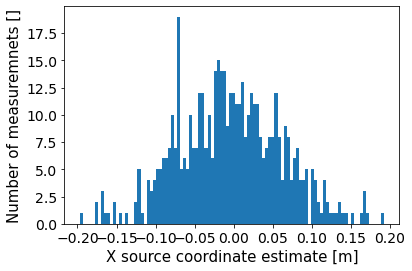

(0.06632507686118669, 0.06720533540878128)
DETECTOR1: 
 0.06715725760146685


In [33]:
def loopstDev(radiation, detector, n_sims, noise=[], A0 = 1000):
    us = []; dus = []
    source00 = [0, 0, A0]
    for n in range(n_sims):
        data = combination(radiation, detector, source00, noise)
        u = data['source_locationCF'][0]#; v = data['source_locationCF'][1]
        du = data['sourceCF_stDev'][0]
        us.append(u); dus.append(du)

    plt.hist(us, bins=100)
    plt.xlabel("X source coordinate estimate [m]", fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel("Number of measuremnets []", fontsize = 15)
    plt.yticks(fontsize = 14)

    plt.show()

    return np.std(us), sum(dus)/len(dus)

print(loopstDev(radiation, detector1, 500))

A0 = 1000; source00 = [0, 0, A0]
data = combination(radiation, detector1, source00)
print('DETECTOR1:', "\n", data['sourceCF_stDev'][0])


## Comparison at each grid tile 

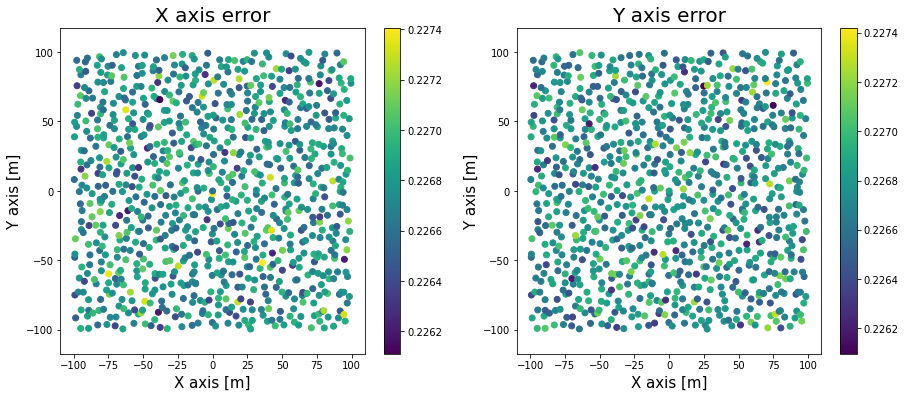

In [19]:
# check if the error is noticably larger for points outside of the center source (0, 0)
def loopOverGrid00(radiation, detector, A0 = 1000, noise = [], N_grid=30):
    A_min, A_max = radiation["A_min"], radiation["A_max"]
    x_max, y_max = detector["x_max"], detector["y_max"]

    source00 = [0, 0, A0]
    data0 = combination(radiation, detector0, source00, noise)
    du0 = data0['sourceCF_stDev'][0]; dv0 = data0['sourceCF_stDev'][1]

    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))
    X = np.zeros((N_grid, N_grid)); Y = np.zeros((N_grid, N_grid))
    Zus = np.zeros((N_grid, N_grid)); Zvs = np.zeros((N_grid, N_grid))
    i, j = 0, 0
    for x in xs:
        for y in ys:
            Source = point_source(x + square_x/2, y + square_y/2, A_min, A_max, x - square_x/2, y - square_y/2); testSource[2] = A0
            data = combination(radiation, detector0, source00, noise)
            du = data['sourceCF_stDev'][0]; dv = data['sourceCF_stDev'][1]
            X[i, j] = Source[0]; Y[i, j] = Source[1]
            Zus[i, j] = du; Zvs[i, j] = dv
            j += 1
        j = 0
        i += 1
    
    X[N_grid - 1, N_grid - 1], Y[N_grid - 1, N_grid - 1] = 0, 0
    Zus[N_grid - 1, N_grid - 1] = du0; Zvs[N_grid - 1, N_grid - 1] = dv0

    fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(15, 6))
    
    test1 = ax1.scatter(X, Y, c=Zus)
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
    ax1.set_title('X axis error', fontsize = 20)
    ax1.axis("equal")

    test2 = ax2.scatter(X, Y, c=Zvs)
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)
    ax2.set_title('Y axis error', fontsize = 20)
    ax2.axis("equal")

    fig.colorbar(test1, ax=ax1)
    fig.colorbar(test2, ax=ax2)
    plt.show()

loopOverGrid00(radiation, detector1)

### Tutorial

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

x = np.linspace(0,1,100)
y = np.linspace(0,10,100) + np.random.normal(0,2,100)
z = np.random.normal(0,1,100)

#set the "c" kwarg to the array of values the colors are based on
plt.scatter(x,y,c=z,cmap='jet')
plt.colorbar(label='z')

print(x, "\n", y, "\n", z)

### Other things

In [ ]:

def loopOverGrid(radiation, detector):
    A_min, A_max = radiation["A_min"], radiation["A_max"]; detector['grid'] = 5
    x_max, y_max, grid = detector["x_max"], detector["y_max"], detector["grid"]
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))
    print(square_x)
    for x in xs:
        for y in ys:
            testSource = point_source(x + square_x/2, y + square_y/2, A_min, A_max, x - square_x/2, y - square_y/2)
            print(testSource)
            compK(radiation, detector0, testSource, [])
            # input('press enter')

loopOverGrid(radiation, detector)


#### By way of fitting?

In [ ]:
# For a range of detector factors from 0 to 1, find the A(K) = ED(K)/ED0

def factor_fit(radiation, detector, testSource1, testSource2):
    K_range = np.linspace(0.01, 0.99, 10)
    data01 = combination(radiation, detector, testSource1, noise); data02 = combination(radiation, detector, testSource2, noise)
    ED01 = data01['effective_dose'][0]; ED02 = data02['effective_dose'][0]
    As1, As2 = [], []
    for K in K_range:
        detector['detector_constant'] = K
        data1 = combination(radiation, detector, testSource1, noise); data2 = combination(radiation, detector, testSource2, noise)
        ED1 = data1['effective_dose'][0]; ED2 = data2['effective_dose'][0]
        A1 = ED1/ED01; A2 = ED2/ED02
        print(A1)
        As1.append(A1)
        As2.append(A2)
    plt.plot(list(K_range), As1, "o", color="b", ms=10)
    plt.plot(list(K_range), As2, "o", color="g", ms=9)

    plt.xlabel("detector coeficient")
    plt.ylabel("A(K)")

    plt.show()


factor_fit(radiation, detector0, testSource1, testSource2)


#### Relation between error and grid

In [ ]:
def func(x, A, B, C):
    return ((A / np.sqrt(B * (x))) + C) 
    
def fit(xs, ys):
    popt, pcov = curve_fit(func, xs, ys, [5.93223505, 70, -0.07433773], method="lm")
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

def errToGrid(radiation, detector1, detector2, testSource):
    errs1, errs2 = [], []
    grids = np.linspace(4, 104, 100)
    for grid in grids:
        detector1["grid"] = int(grid)
        detector2["grid"] = int(grid)
        data1 = combination(radiation, detector1, testSource, []); data2 = combination(radiation, detector2, testSource, [])
        errs1.append(data1["effective_dose"][1]); errs2.append(data2["effective_dose"][1])
    
    popt1, perr1 = fit(grids, errs1); popt2, perr2 = fit(grids, errs2)
    print(popt1, r'±', perr1)

    # plt.plot(grids, np.array(errs1), "o")
    plt.plot(grids, np.array([func(grid, *popt1) for grid in grids]), "-", label="detector 1")
    # plt.plot(grids, np.array(errs2), "o")
    plt.plot(grids, np.array([func(grid, *popt2) for grid in grids]), "-", label="detector 2")

    plt.xlabel("Grid tiles")
    plt.ylabel("Effective dose error")

    plt.legend()
    plt.show()

errToGrid(radiation, detector1, detector2, testSource)
